In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import random
import os
import tensorflow as tf
from tensorflow import keras


# Data Wrangling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/AirbusShipDetection'
main_dir = '/content/working'
TRAIN_DIR = os.path.join(data_dir, 'new_train')
TEST_DIR = os.path.join(data_dir, 'test_v2')
RANDOM_SEED = 77
random.seed(RANDOM_SEED)

In [ ]:
#Sample data/ Whole data
debug = False

In [ ]:
#Code chunk to remove corrupted files
from PIL import Image

from sklearn.model_selection import train_test_split
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg',
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images

def filter_file_names(directory, exclude_list):
    file_names = []
    with os.scandir(directory) as entries:
        for entry in entries:
            if entry.name not in exclude_list and entry.is_file():
                file_names.append(entry.name)
    return file_names

train_names = filter_file_names(TRAIN_DIR, exclude_list)
test_names = filter_file_names(TEST_DIR, exclude_list)




In [ ]:
# Convert the list to a DataFrame
df = pd.DataFrame({'File Name': train_names})

# Write the DataFrame to a CSV file
df.to_csv('/content/drive/MyDrive/Airbus ship detection/train_names.csv', index=False)


# Convert the list to a DataFrame
df = pd.DataFrame({'File Name': test_names})

# Write the DataFrame to a CSV file
df.to_csv('/content/drive/MyDrive/Airbus ship detection/test_names.csv', index=False)

In [ ]:

df = pd.read_csv('/content/drive/MyDrive/New_data/train_names.csv')

train_names1 = df['File Name']


df = pd.read_csv('/content/drive/MyDrive/New_data/test_names.csv')

test_names1 = df['File Name']

print(len(train_names1), len(test_names1))

42556 15606


In [ ]:
#Code to use filter available images in train_ship_segmentation file

# Path to the folder containing the images
image_folder = '/content/drive/MyDrive/Airbus ship detection/airbus-ship-detection/train_v2'

# Path to the CSV file
csv_file = '/content/drive/MyDrive/Airbus ship detection/airbus-ship-detection/train_ship_segmentations_v2.csv'

# Get the list of image names in the folder
image_names = [os.path.splitext(filename)[0] + '.jpg' for filename in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, filename))]

# Read the CSV file
data = pd.read_csv(csv_file)

# Filter the data based on image names
filtered_data = data[data['ImageId'].isin(image_names)]

# Save the filtered data to a new CSV file
filtered_data.to_csv('/content/drive/MyDrive/Airbus ship detection/airbus-ship-detection/train_ship_segmentations_v4.csv',index=False)

In [ ]:
# training dataset
rle = data_dir + '/train_ship_segmentations_v3.csv'
annotations = pd.read_csv(rle)


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/New_data/train_ship_segmentations_v3.csv")
df['EncodedPixels'] = df['EncodedPixels'].astype('string')

# Delete corrupted images
CORRUPTED_IMAGES = ['6384c3e78.jpg']
df = df.drop(df[df['ImageId'].isin(CORRUPTED_IMAGES)].index)

# Dataframe that contains the segmentation for each ship in the image.
instance_segmentation = df

# Dataframe that contains the segmentation of all ships in the image.
image_segmentation = df.groupby(by=['ImageId'])['EncodedPixels'].apply(lambda x: np.nan if pd.isna(x).any() else ' '.join(x)).reset_index()

#### Rle deocde and data prep

In [ ]:
def rle_to_mask(rle: str, shape=(768, 768)):
    '''
    :param rle: run length encoded pixels as string formated
           shape: (height,width) of array to return
    :return: numpy 2D array, 1 - mask, 0 - background
    '''
    encoded_pixels = np.array(rle.split(), dtype=int)
    starts = encoded_pixels[::2] - 1
    ends = starts + encoded_pixels[1::2]
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def mask_to_rle(img, shape=(768, 768)) -> str:
    """
    :param img: numpy 2D array, 1 - mask, 0 - background
           shape: (height,width) dimensions of the image
    :return: run length encoded pixels as string formated
    """
    img = img.astype('float32')
    img = cv2.resize(img, shape, interpolation=cv2.INTER_AREA)
    img = np.stack(np.vectorize(lambda x: 0 if x < 0.1 else 1)(img), axis=1)
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
IMAGES_WITHOUT_SHIPS_NUMBER = 25000

# reduce the number of images without ships
images_without_ships = image_segmentation[image_segmentation['EncodedPixels'].isna()]['ImageId'].values[:IMAGES_WITHOUT_SHIPS_NUMBER]
images_with_ships = image_segmentation[image_segmentation['EncodedPixels'].notna()]['ImageId'].values
# images_list = np.append(images_without_ships, images_with_ships)
images_list = images_with_ships

# remove corrupted images
images_list = np.array(list(filter(lambda x: x not in CORRUPTED_IMAGES, images_list)))

In [ ]:
VALIDATION_LENGTH = 2000
TEST_LENGTH = 2000
TRAIN_LENGTH = len(images_list) - VALIDATION_LENGTH - TEST_LENGTH
BATCH_SIZE = 16
BUFFER_SIZE = 1000
IMG_SHAPE = (256, 256)
NUM_CLASSES = 2

In [ ]:
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a])

def load_train_image(tensor) -> tuple:
    path = tf.get_static_value(tensor).decode("utf-8")

    image_id = path.split('/')[-1]
    input_image = cv2.imread(path)
    input_image = tf.image.resize(input_image, IMG_SHAPE)
    input_image = tf.cast(input_image, tf.float32) / 255.0

    encoded_mask = image_segmentation[image_segmentation['ImageId'] == image_id].iloc[0]['EncodedPixels']
    input_mask = np.zeros(IMG_SHAPE + (1,), dtype=np.int8)
    if not pd.isna(encoded_mask):
        input_mask = rle_to_mask(encoded_mask)
        input_mask = cv2.resize(input_mask, IMG_SHAPE, interpolation=cv2.INTER_AREA)
        input_mask = np.expand_dims(input_mask, axis=2)
    one_hot_segmentation_mask = one_hot(input_mask, NUM_CLASSES)
    input_mask_tensor = tf.convert_to_tensor(one_hot_segmentation_mask, dtype=tf.float32)

    class_weights = tf.constant([0.0005, 0.9995], tf.float32)
    sample_weights = tf.gather(class_weights, indices=tf.cast(input_mask_tensor, tf.int32), name='cast_sample_weights')

    return input_image, input_mask_tensor, sample_weights

images_list = tf.data.Dataset.list_files([f'{TRAIN_DIR}/{name}' for name in images_list], shuffle=True)
train_images = images_list.map(lambda x: tf.py_function(load_train_image, [x], [tf.float32, tf.float32]), num_parallel_calls=tf.data.AUTOTUNE)

validation_dataset = train_images.take(VALIDATION_LENGTH)
test_dataset = train_images.skip(VALIDATION_LENGTH).take(TEST_LENGTH)
train_dataset = train_images.skip(VALIDATION_LENGTH + TEST_LENGTH)

train_batches = (
    train_dataset
    .repeat()
    .batch(BATCH_SIZE))

validation_batches = validation_dataset.batch(BATCH_SIZE)

test_batches = test_dataset.batch(BATCH_SIZE)

In [ ]:
import pandas as pd

# Assuming you have the validation_batches variable containing the validation dataset

# Create empty lists to store the ImageId and EncodedPixels
image_ids = []
encoded_pixels = []

# Iterate over the validation dataset to extract the ImageId and EncodedPixels
for images, masks in validation_batches:
    for image, mask in zip(images.numpy(), masks.numpy()):
        # Convert the image and mask tensors to NumPy arrays
        image_arr = image.astype('uint8')
        mask_arr = mask.squeeze().astype('uint8')

        # Resize the image and mask arrays to the desired shape
        image_resized = cv2.resize(image_arr, IMG_SHAPE[:2])
        mask_resized = cv2.resize(mask_arr, IMG_SHAPE[:2], interpolation=cv2.INTER_NEAREST)

        # Convert the mask to RLE format
        rle_string = mask_to_rle(mask_resized)

        # Extract the ImageId from the image path
        image_id = "img_" + str(len(image_ids) + 1).zfill(6)

        # Append the ImageId and EncodedPixels to the lists
        image_ids.append(image_id)
        encoded_pixels.append(rle_string)

# Create a DataFrame using the ImageId and EncodedPixels lists
validation_df = pd.DataFrame({"ImageId": image_ids, "EncodedPixels": encoded_pixels})

# Print the shape of the validation DataFrame
print(f"Validation DataFrame shape: {validation_df.shape}")

# Save the validation DataFrame to a CSV file
validation_df.to_csv('/content/drive/MyDrive/New_data/validation_df.csv', index=False)

In [ ]:
validation_df = pd.read_csv("/content/drive/MyDrive/New_data/validation_df.csv")

In [ ]:
true_masks = []
for rle_string in validation_df['EncodedPixels']:
    if pd.isnull(rle_string):
        # If no mask, create an empty one
        mask = np.zeros((768, 768), dtype=np.uint8)
    else:
        # Otherwise, create a mask from the RLE string
        mask = rle_to_mask(rle_string, shape=(768, 768))
    true_masks.append(mask)

true_masks = np.array(true_masks)

## UNet model

In [ ]:
#  pip install tensorflow_addons

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Encoder Block
def encoder_block(input_tensor, num_filters):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

# Encoder
def encoder(inputs):
    encoder0_pool, encoder0 = encoder_block(inputs, 32)
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
    encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
    return encoder4_pool, [encoder0, encoder1, encoder2, encoder3, encoder4]

# Decoder Block
def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder

# Decoder
def decoder(encoder_pool, encoder_features):
    encoder0, encoder1, encoder2, encoder3, encoder4 = encoder_features
    decoder4 = decoder_block(encoder_pool, encoder4, 512)
    decoder3 = decoder_block(decoder4, encoder3, 256)
    decoder2 = decoder_block(decoder3, encoder2, 128)
    decoder1 = decoder_block(decoder2, encoder1, 64)
    decoder0 = decoder_block(decoder1, encoder0, 32)
    return decoder0

# UNet Model
def unet():
    inputs = keras.Input(shape=IMG_SHAPE + (3,))
    encoder_pool, encoder_features = encoder(inputs)
    outputs = decoder(encoder_pool, encoder_features)
    outputs = layers.Conv2D(NUM_CLASSES, (1, 1), activation='softmax')(outputs)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
import keras.backend as K

def dice(targets, inputs, smooth=1e-6):
    axis = [1,2,3]
    intersection = K.sum(targets * inputs, axis=axis)
    dice = (2 * intersection + smooth) / (K.sum(targets, axis=axis) + K.sum(inputs, axis=axis) + smooth)
    return dice

def bce_loss(targets, inputs, smooth=1e-6):
    axis = [1,2,3]
    loss = K.sum(targets * tf.math.log(inputs + smooth) + (1 - targets) * tf.math.log(1 - inputs + smooth), axis=axis)
    return - loss

def bce_dice_loss(targets, inputs):
    return bce_loss(targets, inputs) - tf.math.log(dice(targets, inputs))

In [ ]:
class IoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes: int, target_class_ids: list, sparse_y_true: bool, sparse_y_pred: bool,
                 axis: int = -1, name=None, dtype=None):
        super(IoU, self).__init__(name=name, dtype=dtype)
        self.num_classes = num_classes
        self.target_class_ids = target_class_ids
        self.sparse_y_true = sparse_y_true
        self.sparse_y_pred = sparse_y_pred
        self.axis = axis

        # Variable to accumulate the predictions in the confusion matrix.
        self.total_cm = self.add_weight(
            'total_confusion_matrix',
            shape=(num_classes, num_classes),
            initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
          """Accumulates the confusion matrix statistics."""
          y_true_shape = tf.shape(y_true)
          y_pred_shape = tf.shape(y_pred)

          y_true = tf.reshape(y_true, tf.concat([[-1], y_pred_shape[1:]], 0))

          if not self.sparse_y_true:
              y_true = tf.argmax(y_true, axis=self.axis)
          if not self.sparse_y_pred:
              y_pred = tf.argmax(y_pred, axis=self.axis)

          y_true = tf.cast(y_true, self._dtype)
          y_pred = tf.cast(y_pred, self._dtype)

          # Flatten the input if its rank > 1.
          if y_pred.shape.ndims > 1:
              y_pred = tf.reshape(y_pred, [-1])

          if y_true.shape.ndims > 1:
              y_true = tf.reshape(y_true, [-1])

          if sample_weight is not None:
              sample_weight = tf.reshape(sample_weight, [-1, 128, 128])
              sample_weight = tf.cast(sample_weight, self._dtype)
              if sample_weight.shape.ndims > 1:
                  sample_weight = tf.reshape(sample_weight, [-1])

          # Accumulate the prediction to current confusion matrix.
          current_cm = tf.math.confusion_matrix(y_true, y_pred, self.num_classes, weights=sample_weight, dtype=self._dtype)
          return self.total_cm.assign_add(current_cm)


    def reset_state(self):
        tf.keras.backend.set_value(
            self.total_cm, np.zeros((self.num_classes, self.num_classes))
        )

    def result(self):
        """Compute the intersection-over-union via the confusion matrix."""
        sum_over_row = tf.cast(
            tf.reduce_sum(self.total_cm, axis=0), dtype=self._dtype)
        sum_over_col = tf.cast(
            tf.reduce_sum(self.total_cm, axis=1), dtype=self._dtype)
        true_positives = tf.cast(
            tf.linalg.tensor_diag_part(self.total_cm), dtype=self._dtype)

        # sum_over_row + sum_over_col = 2 * true_positives + false_positives + false_negatives.
        denominator = sum_over_row + sum_over_col - true_positives

        # Only keep the target classes
        true_positives = tf.gather(true_positives, self.target_class_ids)
        denominator = tf.gather(denominator, self.target_class_ids)

        # If the denominator is 0, we need to ignore the class.
        num_valid_entries = tf.reduce_sum(
            tf.cast(tf.not_equal(denominator, 0), dtype=self._dtype))

        iou = tf.math.divide_no_nan(true_positives, denominator)

        return tf.math.divide_no_nan(
            tf.reduce_sum(iou, name='mean_iou'), num_valid_entries)

    def get_config(self):
        config = {
            "num_classes": self.num_classes,
            "target_class_ids": self.target_class_ids,
            "sparse_y_true": self.sparse_y_true,
            "sparse_y_pred": self.sparse_y_pred,
            "axis": self.axis,
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
# F2 Score metric
class F2Score(tf.keras.metrics.Metric):
    def __init__(self, name='f2_score', threshold=0.5, **kwargs):
        super(F2Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros') # true positives
        self.fp = self.add_weight(name='fp', initializer='zeros') # false positives
        self.fn = self.add_weight(name='fn', initializer='zeros') # false negatives

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.where(y_pred >= self.threshold, 1., 0.) # apply threshold
        self.tp.assign_add(tf.reduce_sum(y_true * y_pred)) # calculate true positives
        self.fp.assign_add(tf.reduce_sum((1 - y_true) * y_pred)) # calculate false positives
        self.fn.assign_add(tf.reduce_sum(y_true * (1 - y_pred))) # calculate false negatives

    def result(self):
        precision = self.tp / (self.tp + self.fp + 1e-5) # calculate precision
        recall = self.tp / (self.tp + self.fn + 1e-5) # calculate recall
        return (1 + 2**2) * ((precision * recall) / (2**2 * precision + recall + 1e-5)) # calculate F2 score

    def reset_states(self):
        self.tp.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)


# Mean Average Precision (mAP) at different Intersection over Union (IoU) thresholds
class MAP_IoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes, iou_thresholds=[0.5], name='mean_average_precision', **kwargs):
        super(MAP_IoU, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.iou_thresholds = iou_thresholds
        self.total_precisions = self.add_weight(name='tp', initializer='zeros', shape=(num_classes, len(iou_thresholds)))

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(tf.one_hot(y_true, depth=self.num_classes), tf.bool)
        y_pred = tf.cast(tf.one_hot(tf.argmax(y_pred, axis=-1), depth=self.num_classes), tf.bool)

        for i in range(self.num_classes):
            y_true_c = tf.cast(y_true[..., i], tf.float32)
            y_pred_c = tf.cast(y_pred[..., i], tf.float32)
            intersection = tf.reduce_sum(y_true_c * y_pred_c)
            union = tf.reduce_sum(y_true_c) + tf.reduce_sum(y_pred_c) - intersection + 1e-7
            iou = intersection / union
            precisions = [tf.cast(tf.math.greater_equal(iou, t), tf.float32) for t in self.iou_thresholds]
            self.total_precisions[i].assign_add(tf.reduce_sum(precisions))

    def result(self):
        num_images = tf.reduce_sum(self.total_precisions)
        average_precisions = tf.reduce_sum(self.total_precisions, axis=0) / (num_images + 1e-7)
        return tf.reduce_mean(average_precisions)

    def reset_states(self):
        self.total_precisions.assign(tf.zeros_like(self.total_precisions))


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Trainable params: 9608770


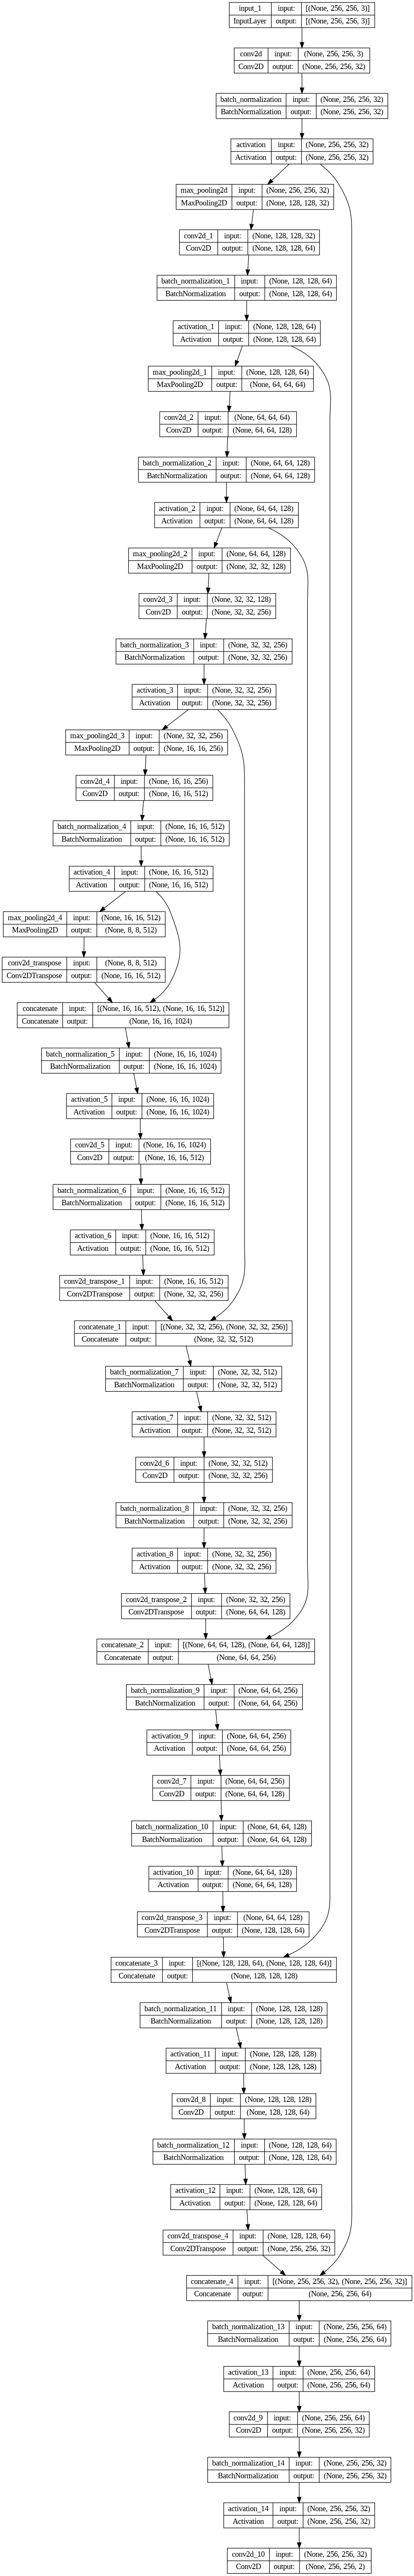

In [ ]:
import tensorflow_addons as tfa
EPOCHS = 6
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

optimizer = tfa.optimizers.RectifiedAdam(
    learning_rate=0.005,
    total_steps=EPOCHS * STEPS_PER_EPOCH,
    warmup_proportion=0.3,
    min_lr=0.0001,
)
optimizer = tfa.optimizers.Lookahead(optimizer)

loss = tf.keras.losses.CategoricalCrossentropy()
mIoU = IoU(num_classes=2, target_class_ids=[0, 1], sparse_y_true=False, sparse_y_pred=False, name='mean-IoU')

model = unet()
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[mIoU],)

trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print(f'Trainable params: {trainable_params}')

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
import tensorflow_addons as tfa
EPOCHS = 12
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

optimizer = tfa.optimizers.RectifiedAdam(
    learning_rate=0.005,
    total_steps=EPOCHS * STEPS_PER_EPOCH,
    warmup_proportion=0.3,
    min_lr=0.0001,
)
optimizer = tfa.optimizers.Lookahead(optimizer)

loss = tf.keras.losses.CategoricalCrossentropy()
mIoU = IoU(num_classes=2, target_class_ids=[0, 1], sparse_y_true=False,
           sparse_y_pred=False, name='mean-IoU')
f2score = F2Score(name = 'f2_score')
MAP_metric = MAP_metric(num_classes = 2,  name='mean_average_precision',)

model = unet()
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[mIoU,f2score,MAP_metric],)

In [ ]:
import pickle

checkpoint_filepath = '/content/drive/MyDrive/New_data/model-checkpoint'
save_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mean-IoU',
    mode='max',
    save_best_only=True
)

model_history = model.fit(train_batches,
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=validation_batches,
                          callbacks=[save_callback])
model.load_weights(checkpoint_filepath)

with open("/content/drive/MyDrive/New_data/model_history.pkl", "wb") as file:
    pickle.dump(model_history.history, file)

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/New_data/model-checkpoint'
model.load_weights(checkpoint_filepath)

In [ ]:
import tensorflow as tf


# Load the model
loaded_model = tf.saved_model.load(checkpoint_filepath)

In [ ]:
import pickle

# Specify the path to the pickle file
history_file = '/content/drive/MyDrive/New_data/model_history.pkl'

# Load the model history from the pickle file
with open(history_file, 'rb') as file:
    model_history = pickle.load(file)

In [ ]:
loss = model_history['loss']
val_loss = model_history['val_loss']

plt.figure()
plt.plot(range(len(loss)), loss,  label='Training loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

In [ ]:
mIoU = model_history['mean-IoU']
val_mIoU = model_history['val_mean-IoU']

plt.figure()
plt.plot(range(len(mIoU)), mIoU, 'm', label='Training mean IoU')
plt.plot(range(len(val_mIoU)), val_mIoU, 'y', label='Validation mean IoU')

plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

In [ ]:
def predict(test_batches):
    all_preds = []
    for images, _ in test_batches:  # Ignore the second output (the masks)
        preds = model.predict(images)
        all_preds.append(preds)
    return np.concatenate(all_preds, axis=0)


In [ ]:
from sklearn.metrics import fbeta_score,average_precision_score

def calculate_f2_score(y_true, y_pred):
    return fbeta_score(y_true.flatten(), y_pred.flatten(), beta=2)

def calculate_average_precision(y_true, y_pred):
    return average_precision_score(y_true.flatten(), y_pred.flatten())


In [ ]:
# Initialize accumulators
f2_accumulator = 0
map_accumulator = 0

# For each batch in the validation dataset
for images, true_masks in validation_batches:
    # Predict masks
    predicted_masks = model.predict(images)

    # Convert prediction to binary
    predicted_masks = (predicted_masks > 0.5).astype(np.uint8)

    # Convert EagerTensor objects to NumPy arrays
    true_masks = true_masks.numpy()
    #predicted_masks = predicted_masks.numpy()

    # Calculate F2 score and MAP for each image in the batch and accumulate
    for true_mask, predicted_mask in zip(true_masks, predicted_masks):
        f2_accumulator += calculate_f2_score(true_mask, predicted_mask)
        map_accumulator += calculate_average_precision(true_mask, predicted_mask)

# Calculate average F2 score and MAP over the whole validation set
f2_score = f2_accumulator / len(validation_batches)
map_score = map_accumulator / len(validation_batches)

print(f'F2 Score on the validation set: {f2_score}')
print(f'Mean Average Precision on the validation set: {map_score}')


In [ ]:
def predict_mask(image):
    image = np.expand_dims(image, axis=0)
    pred_mask = model.predict(image)[0].argmax(axis=-1)
    return pred_mask

# Results analysis

1/1 [==============================] - 0s 478ms/step
pred_mask:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
1/1 [==============================] - 0s 21ms/step
pred_mask:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
1/1 [==============================] - 0s 22ms/step
pred_mask:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
1/1 [==============================] - 0s 24ms/step
pred_mask:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
1/1 [==============================] - 0s 24ms/step
pred_mask:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


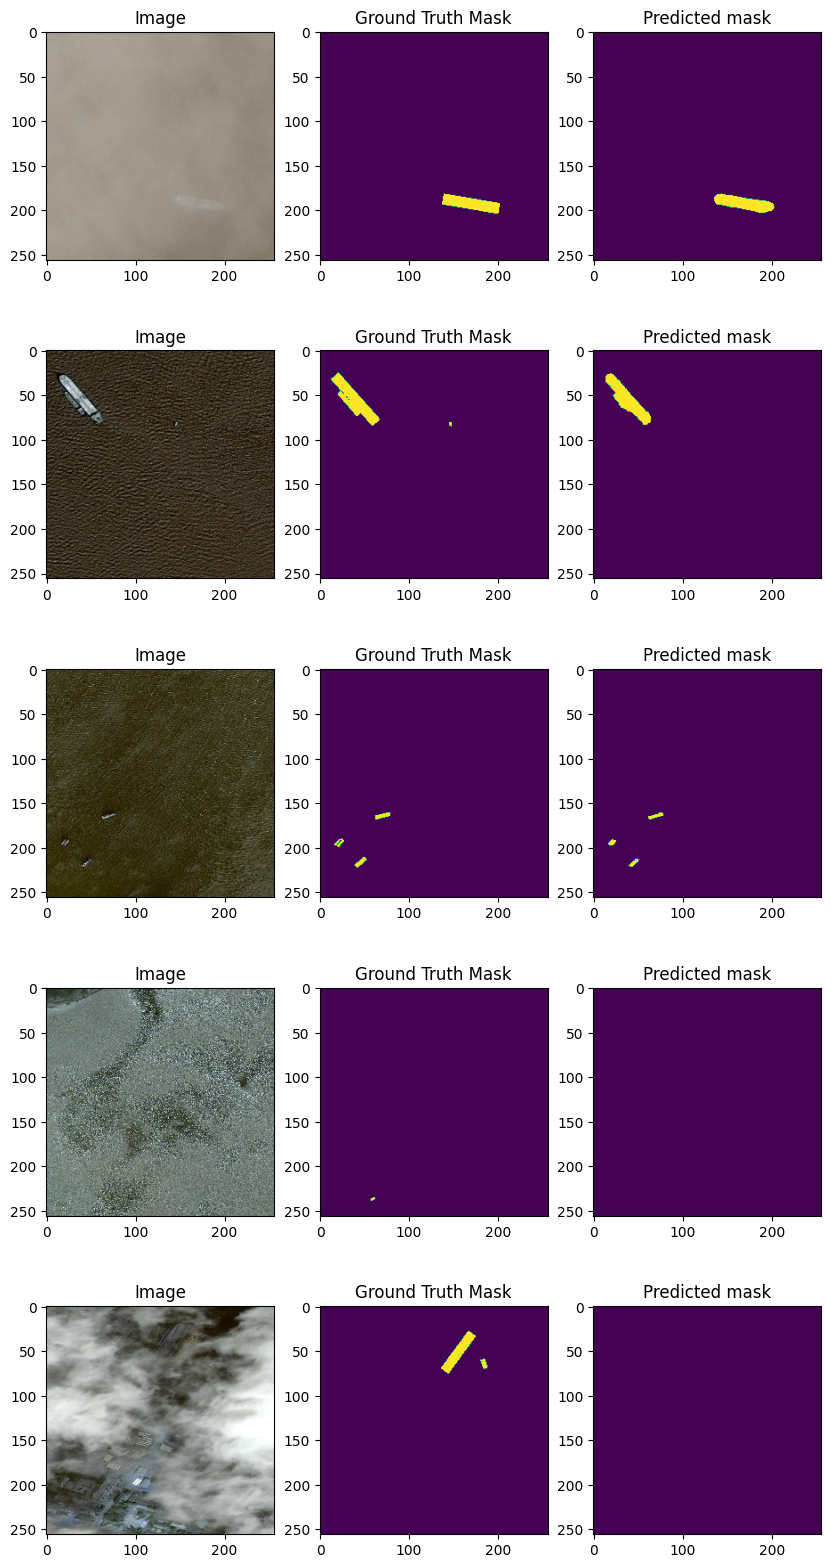

In [ ]:
N = 5

f,ax = plt.subplots(N, 3, figsize=(10, 4 * N))
i = 0
for image, mask in test_dataset.take(N):
    mask = mask.numpy().argmax(axis=-1)
    ax[i, 0].imshow(image)
    ax[i, 0].set_title('Image')
    ax[i, 1].imshow(mask)
    ax[i, 1].set_title('Ground Truth Mask')

    pred_mask = predict_mask(image)
    print("pred_mask: ", pred_mask)
    ax[i, 2].imshow(pred_mask)
    ax[i, 2].set_title('Predicted mask')
    i += 1

plt.show()